# Introduction to Machine Learning (CSCI-UA.473)

## Lab 4: Logistic Regression Recap, Metrics for Classification and Support Vector Machines
### Date: March 3rd, 2022

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
# Install autograd:
#!conda install -c conda-forge autograd

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad,elementwise_grad

import scipy.optimize

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection

# For the plots in this notebook we will use a widget to get interactive and better looking plots! 
# follow these instructions to set up matplotlib widget for Jupyter Lab
# https://github.com/matplotlib/jupyter-matplotlib#installation
# Specifically you will need to install the widget using : conda install -c conda-forge ipympl
# To enable the widget run the following two commands :
# jupyter nbextension install --py --symlink --sys-prefix --overwrite ipympl
#jupyter nbextension enable --py --sys-prefix ipympl
# %matplotlib widget

## Part 1: Logistic Regression using Synthetic Data and Autograd

We will play around with the logistic regression model implemented from scratch and trained using autograd on synthetic data. 

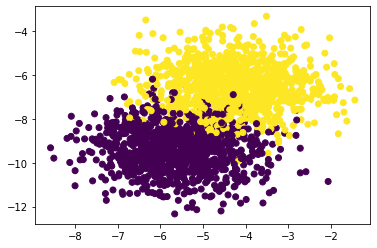

In [5]:
# random_seed = numpy.random.randint(0,100)
random_seed = 65

x, y = datasets.make_blobs(n_samples=2000, centers=2, n_features=2, random_state=random_seed)

fig = plt.figure()
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

Now we have a set of data points $\{(x_{1}, y_{1}), (x_{2}, y_{2}), ... , (x_{n}, y_{n})\}$, where $x_{i} \in R^{d}$ are the feature vectors and $y_{i} \in \{0, 1\}$ are the class labels.

### Split the data into training set and validation set
We consider the first 1500 points as our training set and the remaining 500 as our validation set. 
<b>Is this correct?</b> 

In [6]:
x_train, y_train = x[:1500], y[:1500]
x_val, y_val = x[1500:], y[1500:]

# sanity check
assert len(x_train) == len(y_train) == 1500
assert len(x_val) == len(y_val) == 500

# should we check anything else? 

### Build the model
Logistic regression model outputs the posterior probability of the class label to be equal to 1. 
$$p_{+} = p(y = 1|x) = \frac{1}{1 + e^{-w \cdot x + b}},$$ 
where $w \in R^{d}$ and $b \in R$.

Sigmoid function is used to convert the output of the linear operation into probabilities. 

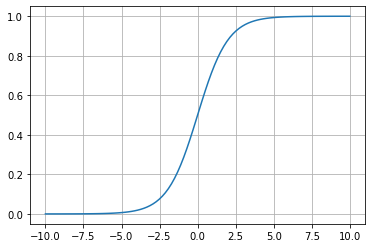

In [7]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

def plot_function(f):
    x = numpy.linspace(-10,10,100)
    y = f(x)
    
    return plt.plot(x,y)

plt.figure()
plot_function(sigmoid)
plt.grid(True)
plt.show()

In [8]:
def logistic_unit(x, w, b):
    """This function computes logistic unit as defined $p_{+}$ above
    :param x: input x with n_dim features
    :param w: weght vector
    :param b: bias vector
    """
    
    # operator @ means matrix multiplication in python <3.5
    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.matmul.html#numpy.matmul
    
    pre_sigmoid = x @ w + b
    logit = sigmoid(pre_sigmoid)
    
    return logit

### Loss Function
The loss function of the logistic regression is given by: 

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

Note that $p_{+}$ depends on $x$ and $w$. 

In [9]:
NEAR_ZERO = 1e-12

def loss_function(x, y, w, b):
    """This function computes the loss (distance)
    :param logits: output from logistic unit
    :param labels: target label
    """
    logits = logistic_unit(x,w,b)
    labels = y
    
    loss = -(labels * numpy.log(logits + NEAR_ZERO) + (1 - labels) * numpy.log(1 - logits + NEAR_ZERO))
    
    return loss

Now lets do a sanity check and compute the loss between the target and prediction given a randomly initialized model.

In [10]:
# sanity check
n_dim=2
w0 = 0.1 * numpy.random.randn(n_dim)
b0 = 0.0

inp = x_train[0]
label = y_train[0]

out = logistic_unit(inp, w0, b0)
assert (out < 1) and (out > 0)  # why?

loss = loss_function(inp, label, w0, b0)
print(loss)

0.608229558714091


### Use Autograd for computing the derivatives and train the model
As discussed in the previous lab, with Autograd we do not need to compute the gradients by hand and code it. This is very handy when we have huge DAG (Directed Acyclic Graph) computations.
There is an active line of research in automatic differentiation, curious students are adviced to read this:
http://jmlr.org/papers/volume18/17-468/17-468.pdf

In [11]:
loss_grad_w = elementwise_grad(loss_function, 2) # partial derivative wrt the weights w (3rd input)
loss_grad_b = elementwise_grad(loss_function, 3) # partial derivative wrt the bias b (4th input)

In [12]:
n_iter = 10000
eta = .0001   # Learning rate
w = numpy.copy(w0)
b = numpy.copy(b0)

loss_log = []

for ni in tqdm(range(n_iter)):
    dw = loss_grad_w(x_train, y_train, w, b)
    db = loss_grad_b(x_train, y_train, w, b)
    w -= eta * dw
    b -= eta * db
    
    loss = numpy.mean(loss_function(x_train, y_train, w, b))
    loss_log.append(loss)

100%|██████████| 10000/10000 [00:06<00:00, 1450.85it/s]


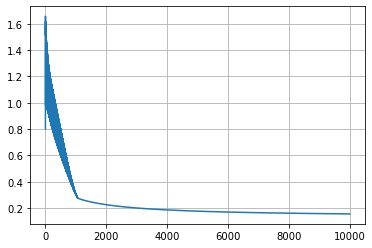

In [13]:
# lets plot the running element-wise loss value
plt.figure()
plt.plot(loss_log)
plt.grid(True)
plt.show()

### Plot the data: the actual data and the model (hyperplane)
We start with first defining some visualization routines and then we do the actual plotting. 

In [14]:
#Justsome visualization routines. As always, don't focus on the details of these routines too much!
# visualize data 
def vis_data(x, y = None):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], 'b'+'o' if y_ == 0 else 'y'+'+')
    plt.grid('on')
    
def vis_hyperplane(w, b, typ='k--'):

    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + b)/w[1]
    intercept1 = -(w[0] * m1 + b)/w[1]
    
    plt1, = plt.plot([m0, m1], [intercept0, intercept1], typ)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

def vis_decision_boundary_contour(w, b, typ='k--'):
    
    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    pred = logistic_unit(x_tra_, w, b)
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)
    
    plt.colorbar(plt1)
    
    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

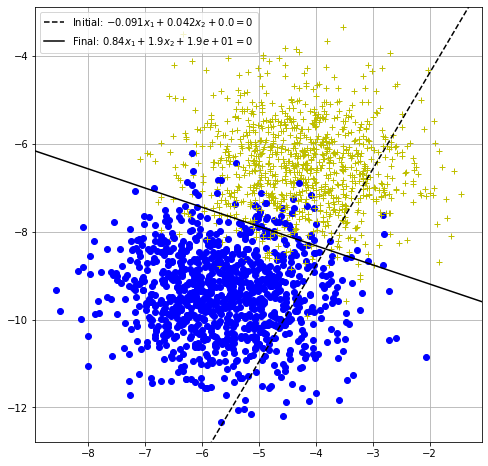

In [15]:
plt.figure(figsize=(8,8))

vis_data(x, y)

plt0 = vis_hyperplane(w0, b0, 'k--')
plt1 = vis_hyperplane(w, b, 'k-')
plt.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)+[b0]),
        'Final: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w)+[b])],
           loc='best')

plt.show()

## Part 2: Logistic Regression for Breast Cancer Classification using Sklearn

We will now implement and train another logistic regression model using Sci-kit learn. The goal will be to implement the model, which given a new data point infers the probability of breast cancer. 

Helper method below copied from: [Helper Method](https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset)

In [16]:
# General helper method to convert sci-kit datasets to Pandas DataFrame.
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

Let's eyeball the data a little bit in a quick and hacky manner. Always a good practice to see what the data looks like. **The training data of course!**

In [17]:
cancer_dataset = datasets.load_breast_cancer() # Load the data and convert to a pandas dataframe
df = sklearn_to_df(cancer_dataset)

print(df.head()) # Print out the first five data points.

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

Let's gather a few summary statistics about our data. Again, always a good practice. 

N = 569 data points


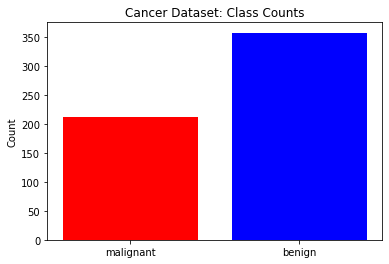

In [18]:
N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1], df['target'].value_counts(ascending = True), color = ['r', 'b'], tick_label = cancer_dataset.target_names)
plt.ylabel('Count')
plt.title('Cancer Dataset: Class Counts');

This dataset is unbalanced because there are more examples of benign cancer than malignant.  This is typical of many real-life datasets where we are sometimes limited in how many training examples we have.  Let's split our data into a training and validation set.  We'll use a 80/20 split.

In [19]:
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
train_data, val_data = model_selection.train_test_split(df, test_size = 0.2) # 0.2 is 20% validation data.

# Split the features from the class labels.
X_train = train_data.drop('target', axis = 1) # We drop the target from the features.  
X_val  = val_data.drop('target', axis = 1)  # Note that this does not operate inplace.
 
y_train = train_data['target']
y_val  = val_data['target']

Now that our data is loaded and split we can train a logistic regression model.  For the optimization we use the "liblinear" solver.  There are many other solvers that are also available, such as Newton CG for example.  For more information: [Solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [20]:
# Now fit a logistic regression model.
model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model.fit(X_train, y_train);

The model is trained so we can validate it on our validation set.  The Sci-kit metrics module contains many useful functions for this purpose.  We try out a few of them below. 

Let us first briefly explain some of these metrics we will use.  

#### Accuracy 
Accuracy is obviously the percentage of all correctly classified examples in our test set.  

#### Confusion Matrix
The confusion matrix is the following matrix:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$
Notice that the diagonal entries are the examples that are correctly classified.  

#### Precision Score
The precision score is the percentage 
$$
\text{Precision } = \frac{C_{00}}{C_{00} + C_{01}}.
$$
So it is the percentage of predicted malignant tumors that we classify correctly.  

#### Recall Score 
The recall score is the percentage
$$
\text{Recall } = \frac{C_{00}}{C_{00} + C_{10}}
$$
So it is the percentage of malignant tumors that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

In [27]:
pred = model.predict(X_val)

# See the percentage of examples that are correctly classified.
accuracy = metrics.accuracy_score(y_val, pred) 
print("Accuracy = {:0.1f}%".format(accuracy * 100))

# The matrix of predictions and true values for each class.
conf_matrix = metrics.confusion_matrix(y_val, pred)
print("Confusion matrix = ")
print(conf_matrix)

# Precision score.
precision = metrics.precision_score(y_val, pred)
print("Precision = {:0.1f}%".format(100 * precision))

# Recall score.
recall = metrics.recall_score(y_val, pred)
print("Recall    = {:0.1f}%".format(100 * recall))

Accuracy = 96.8%
Confusion matrix = 
[[ 55   4]
 [  2 127]]
Precision = 96.9%
Recall    = 98.4%


/Users/xianhuizhu/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Support Vector Machines
We will now play around with the support vector machine. We will first compare them to a standard logistic regression model. Then we will see how they work on datasets which are not linearly separable. 

Import some necessary packages

In [2]:
# Start by importing the packages we'll need.
import numpy as np
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

### Implement Linear SVMs
We will implement a linear SVM for the task of breast cancer classification. 

First load the dataset and split it into training and validation set. 

In [3]:
# We'll set a random seed first.
np.random.seed(19)

# First load the data.
data = datasets.load_breast_cancer()
X = data.data   # The features.
y = data.target # The targets.

# Print the dataset sizes.
print('Shape of X = ', X.shape)
print('Shape of y = ', y.shape)

# Split the data into a training and test set.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)

Shape of X =  (569, 30)
Shape of y =  (569,)


Now train a linear SVM using scikit-learn. In addition also train a logistic regression model also using scikit-learn.

In [4]:
# Train the linear SVM.

svm = LinearSVC(dual = False) # Uses the squared-hinge loss function when fitting the model.
svm.fit(X_train, y_train)

# Now evaluate it on the test points.
y_pred = svm.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Linear SVM validation accuracy = {:0.1f}%'.format(100*acc))

# Compare to a simple logistic regression model.

lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Logistic Regression validation accuracy = {:0.1f}%'.format(100*acc))

Linear SVM validation accuracy = 96.3%
Logistic Regression validation accuracy = 95.2%


As we can see, a basic linear SVM already does very well and is comparable to logistic regression.

Let's compare logistic regression with SVM for binary classification.  Suppose that our data has $n$ features and we have trained a logistic regression model with weight vector $\theta_{\mathrm{LR}}\in \mathbb{R}^{n+1}$ as well as a linear SVM with parameters $w_{\mathrm{SVM}}\in \mathbb{R}^n$, and $b_{\mathrm{SVM}}\in \mathbb{R}$.  Assume that the optimal parameters have been found in both cases.  If the data is linearly separable then is it true that $\theta_{\mathrm{LR}} = (b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$? 

If not then why?

**They will not be the same in general.**

Consider the dataset $X = (-5, -1, 1, 2)^T$ and $y = (-1, -1, 1, 1)^T$ (equivalently $y = (0,0,1,1)^T$ for logistic regression).  The SVM parameters will just be $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}}) = (0,1)$.  However, the logistic regression parameters will be slightly different.  Recall the gradient of the loss function for logistic regression is
$$
\nabla_{\theta}J(\theta) = -\sum_{i=1}^4 (y_i - h(X_i;\theta))X_i
$$
where
$$
h(x;\theta) = \frac{1}{1 + \exp(-\theta^Tx)}
$$
However, if we plug all of the values into the gradient we get
$$
\nabla_{\theta}J((b_{\mathrm{SVM}}, w_{\mathrm{SVM}})) = -\left( \frac{5}{1+e^{5}} + \frac{1}{1+e^{1}} + \frac{e^{-1}}{1+e^{-1}} +  \frac{2e^{-2}}{1 + e^{-2}} \right) \neq 0
$$
Since the gradient is non-zero we know that $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$ is not the optimal value for the logistic regression loss function and hence cannot be $\theta_{\mathrm{LR}}$.

### Case of non-linearly separable dataset

If the data is linear separable, then a linear SVM should be able to achieve 100% accuracy.  However, this is rarely the case since even the breast cancer dataset was not exactly linear separable.  We'll use a synthetic dataset to illustrate this.  This data is drawn from a bi-modal Gaussian mixture model.

In [5]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def sample_bimodal_data(N):
    
    # The two modes and covariances.
    mu1 = np.asarray([-1, 0])
    mu2 = np.asarray([1, 0])
    
    cov1 = 2 * np.identity(2)
    cov2 = 2 * np.identity(2)
    
    N1 = N//2   # Number of points in first class.
    N2 = N - N1 # Number of points in second class.
    
    # Sample the random points.
    X1 = np.random.multivariate_normal(mu1, cov1, N1)
    X2 = np.random.multivariate_normal(mu2, cov2, N2)
    Y1 = np.zeros(N1)
    Y2 = np.ones(N2)
    
    # Combine the data.
    X = np.vstack((X1, X2))
    Y = np.concatenate((Y1, Y2), axis = None)
    
    return X,Y

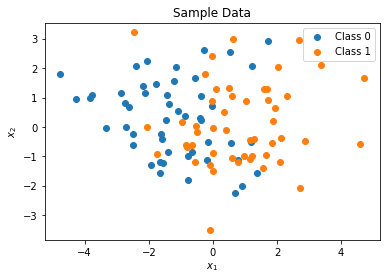

In [6]:
# Plot the sample data.
N = 100
X,Y = sample_bimodal_data(N)

plt.figure(1)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

Increasing the factor in front of the covariances or shifting the centers of the two distributions to be closer to each other will cause the data to overlap more, making it harder to classify. Lets try that! 

#### Using a slack variable C

Since the data is not perfectly linearly separable you'll want to use a slack variable which allows SVM to handle this dataset.  Let's train some models with different values of $C$ and compare them using cross-validation.

In [7]:
# First get the data and split it into training and testing.

N = 100
X, Y = sample_bimodal_data(N)

# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.30, random_state = 981)

SVM accuracy = 66.7%


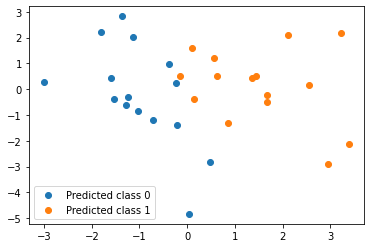

In [8]:
# Define the SVM model to use with a slack variable
svm = LinearSVC(C = 1e-10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 1')
plt.legend()
plt.show()

**Experiment with various different mu1 values and demonstrate SVM accuracy gets worse as mu1 and mu2 get closer**


Let's train some models with different $C$ and compare them use cross-validation.

In [9]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

split = model_selection.KFold(5)
# Get the CV scores.
cv_1 = model_selection.cross_val_score(svm_1, X_train, Y_train, cv = split)
cv_2 = model_selection.cross_val_score(svm_2, X_train, Y_train, cv = split)
cv_3 = model_selection.cross_val_score(svm_3, X_train, Y_train, cv = split)
cv_4 = model_selection.cross_val_score(svm_4, X_train, Y_train, cv = split)

# Print the average scores.
print('C = 10    CV average score = {:0.1f}%'.format(np.mean(cv_1) * 100))
print('C = 1     CV average score = {:0.1f}%'.format(np.mean(cv_2) * 100))
print('C = 1e-3  CV average score = {:0.1f}%'.format(np.mean(cv_3) * 100))
print('C = 1e-7  CV average score = {:0.1f}%'.format(np.mean(cv_4) * 100))

C = 10    CV average score = 72.9%
C = 1     CV average score = 72.9%
C = 1e-3  CV average score = 75.7%
C = 1e-7  CV average score = 77.1%


We see that the model performs slightly differently for different values of the slack variable $C$.  

$$
\min_{w,b,\zeta} \frac{1}{2}w^Tw + C\sum_{i=1}^n \zeta_i,\quad \text{ such that }\quad y_i(w^Tx_i + b) \ge 1 - \zeta_i,\quad \zeta_i \ge 0
$$

See the sci-kit [documentation](https://scikit-learn.org/stable/modules/svm.html) for more details.  We can also plot a curve of the validation score for many different $C$ values which can be helpful for determining the optimal hyperparameter.

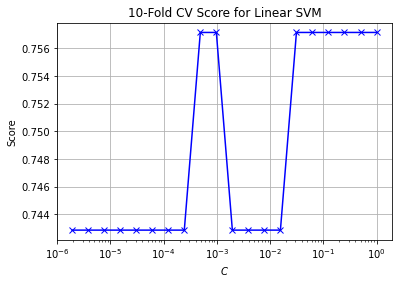

In [14]:
# Get the C values we want to look at.
C = 1/(2**np.arange(0, 20)) # 1,...,1e-6

k = 10 # Kfold CV.
cv_scores = np.zeros(len(C))
split = model_selection.KFold(k)
for i in range(len(C)):
    svm = LinearSVC(C = C[i], dual = False)
    cv_scores[i] = np.mean(model_selection.cross_val_score(svm, X_train, Y_train, cv = split))

plt.figure(2)
plt.semilogx(C, cv_scores, 'b-x')
plt.xlabel(r'$C$')
plt.ylabel(r'Score')
plt.title(r'{:d}-Fold CV Score for Linear SVM'.format(k))
plt.grid();

We can use this plot to find the optimal value of the slack variables based on the cross validation score. Now let's see how our 4 models from earlier actually do on the validation set.

In [11]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

# Fit the models.
svm_1.fit(X_train, Y_train)
svm_2.fit(X_train, Y_train)
svm_3.fit(X_train, Y_train)
svm_4.fit(X_train, Y_train)

# Make the predictions.
pred1 = svm_1.predict(X_val)
pred2 = svm_2.predict(X_val)
pred3 = svm_3.predict(X_val)
pred4 = svm_4.predict(X_val)

# Evaluate the models.
acc1 = metrics.accuracy_score(Y_val, pred1)
acc2 = metrics.accuracy_score(Y_val, pred2)
acc3 = metrics.accuracy_score(Y_val, pred3)
acc4 = metrics.accuracy_score(Y_val, pred4)

print('Linear SVM (C = 10)   accuracy = {:0.1f}%'.format(100*acc1))
print('Linear SVM (C = 1)    accuracy = {:0.1f}%'.format(100*acc2))
print('Linear SVM (C = 1e-3) accuracy = {:0.1f}%'.format(100*acc3))
print('Linear SVM (C = 1e-7) accuracy = {:0.1f}%'.format(100*acc4))

Linear SVM (C = 10)   accuracy = 56.7%
Linear SVM (C = 1)    accuracy = 56.7%
Linear SVM (C = 1e-3) accuracy = 63.3%
Linear SVM (C = 1e-7) accuracy = 66.7%


### Another non-linearly separable dataset

In [12]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def gen_data1(N):
    N1 = N//2
    N2 = N - N1
    t = np.linspace(0, 2*np.pi, N1)
    
    X1 = np.zeros((N1, 2))
    X1[:,0] = 4*np.cos(t) + 0.1*np.random.randn(N1)
    X1[:,1] = 4*np.sin(t) + 0.1*np.random.randn(N1)
    y1 = np.zeros(N1)
    
    X2 = np.random.randn(2*N2)
    X2 = X2.reshape((N2, 2))
    y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2), axis = None) # axis = None means that arrays flattened before use
    
    return X,y

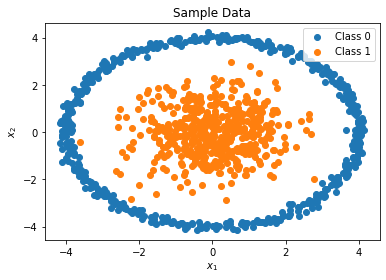

In [13]:
# Plot the data.
N = 1000
X, Y = gen_data1(N)

plt.figure(3)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

In [ ]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'prediced class 1')
plt.legend()
plt.show()

Here the data is not linearly separable although we can very clearly see some separation. If we transform the data by only looking at the radius, then we would be able to linearly separate the data. We will visit this in the next lecture when we talk about kernel SVM's which are much more flexible models and can handle a wider array of datasets.

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

pX = np.vstack(cart2pol(X[:, 0], X[:, 1])).T
print(pX.shape)
plt.figure(4)
plt.scatter(pX[:N//2, 0], pX[:N//2, 1], label = 'Class 0')
plt.scatter(pX[N - N//2:, 0], pX[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$p_1$ (radius)')
plt.ylabel(r'$p_2$ (angle)')
plt.title('Sample Data')
plt.show()

In [ ]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(pX, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))